## Importing Libraries

## Insert MobileNet without FC Layers and Freeze Conv Layers

In [2]:
from tensorflow.keras.applications import MobileNet

# Mobilenet was deigned to work 224x224 pixel input image sizes
img_rows,img_cols = 224,224

#Reloads the mobilenet model without the top or FC layers
MobileNet = MobileNet(weights='imagenet',include_top=False,input_shape=(img_rows,img_cols,3))

#Here we freeze  the last 4 layers
#Layers are set to trainable as true by default
for layer in MobileNet.layers:
    layer.trainable = False

#Lets print our layers
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

17227776/17225924 [==============================] - 3s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False


## Create Function to Define FC layers

In [4]:
def addTopModelMobileNet(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

## FC Layers Creation

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model

num_classes = 10

FC_Head = addTopModelMobileNet(MobileNet,num_classes)

model = Model(inputs = MobileNet.input,outputs = FC_Head)

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

## Data Preperation and Augme

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'monkey_breed/train'
validation_data_dir = 'monkey_breed/validation'

#Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)


#Set batch size
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("monkey_breed_mobileNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 1098
nb_validation_samples = 272

# We only train 5 EPOCHS 
epochs = 5
batch_size = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.6627 - accuracy: 0.6679
Epoch 00001: val_loss improved from inf to 0.21523, saving model to monkey_breed_mobileNet.h5
34/34 [==============================] - 56s 2s/step - loss: 1.6627 - accuracy: 0.6679 - val_loss: 0.2152 - val_accuracy: 0.9258
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.8153
Epoch 00002: val_loss improved from 0.21523 to 0.17081, saving model to monkey_breed_mobileNet.h5
34/34 [==============================] - 57s 2s/step - loss: 0.6213 - accuracy: 0.8153 - val_loss: 0.1708 - val_accuracy: 0.9414
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.8659
Epoch 00003: val_loss improved from 0.17081 to 0.13727, saving model to monkey_breed_mobileNet.h5
34/34 [==============================] - 56s 2s/step - loss: 0.4428 - accuracy: 0.8659 - val_loss: 0.1373 - val_accuracy: 0.9531
Epoch 4/5
34/34 [===========================

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

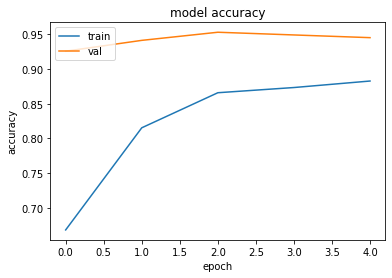

In [23]:
losses = history.history['accuracy']
val_losses = history.history['val_accuracy']
plt.plot(losses)
plt.plot(val_losses)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

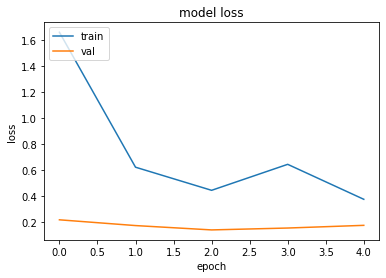

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np

In [56]:
y_pred = model.predict(validation_generator)

In [57]:
y_pred_true = np.argmax(y_pred,axis=1)

In [66]:
label_map = (train_generator.class_indices)

In [68]:
print(classification_report(validation_generator.classes,y_pred_true,target_names=label_map.keys()))

              precision    recall  f1-score   support

          n0       0.95      0.77      0.85        26
          n1       0.97      1.00      0.98        28
          n2       1.00      0.96      0.98        27
          n3       1.00      0.93      0.97        30
          n4       1.00      1.00      1.00        26
          n5       0.93      1.00      0.97        28
          n6       0.93      0.96      0.94        26
          n7       0.84      0.96      0.90        28
          n8       1.00      0.78      0.88        27
          n9       0.81      1.00      0.90        26

    accuracy                           0.94       272
   macro avg       0.94      0.94      0.94       272
weighted avg       0.94      0.94      0.94       272



In [69]:
df_cm = pd.DataFrame(confusion_matrix(validation_generator.classes,y_pred_true),label_map.keys(),label_map.keys())

Text(195.0, 0.5, 'label (ground truth)')

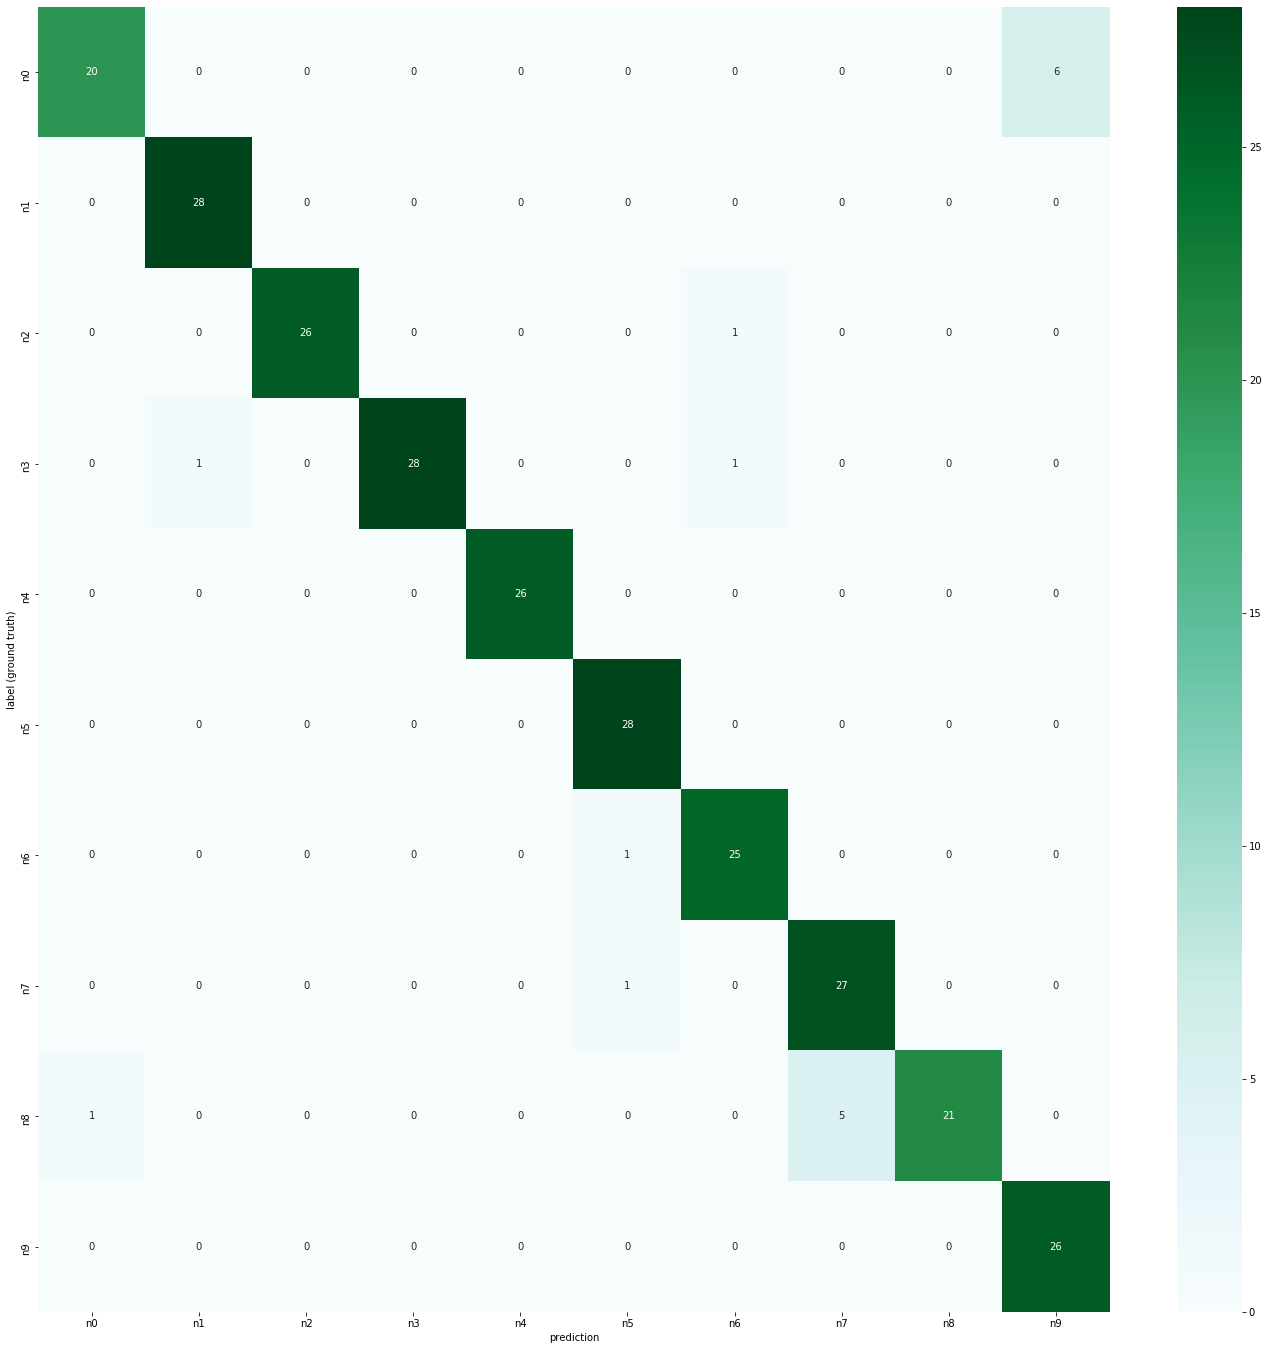

In [70]:
#print('Confusion Matrix')
#print(confusion_matrix(validation_generator.classes,y_pred))
plt.figure(figsize=(24,24))
sns.heatmap(df_cm,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")